In [1]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sym_metanet as metanet
from sym_metanet import (
    Destination,
    Link,
    MainstreamOrigin,
    MeteredOnRamp,
    Network,
    Node,
    engines,
)
C = (4000, 2000,)
tau = 18 / 3600
kappa = 40
eta = 60
delta = 0.0122
a = 1.867
rho_crit = 33.5
rho_max = 180
v_free = 102
def create_demands(time: np.ndarray) -> np.ndarray:
    return np.stack(
        (
            np.interp(time, (2.0, 2.25), (4500, 1000)),
            np.interp(time, (0.0, 0.15, 0.35, 0.5), (500, 1500, 1500, 500)),
            np.interp(time, (0.0, 0.15, 0.35, 0.5), (500, 1500, 1500, 500)),
        )
    )
# build network
Tfin = 2.5

T = 3 / 3600
time = np.arange(0, Tfin, T)

lanes = 2
link_lengths = [1.15,0.30,5.41,1.24,0.68]
num_segments = [5,1,27,6,3]
segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]
N1 = Node(name="N1")
N2 = Node(name="N2")
N3 = Node(name="N3")
N4 = Node(name="N4")
N5 = Node(name="N5")
N6 = Node(name="N6")
N_off1 = Node(name="N_off1")
N_off2 = Node(name="N_off2")


O1 = MainstreamOrigin[cs.SX](name="O1")

O_GL = MeteredOnRamp[cs.SX](C[1], name="O_GL")
O_JC = MeteredOnRamp[cs.SX](C[1], name="O_JC")

D1 = Destination[cs.SX](name="D1")
D_GL = Destination[cs.SX](name="D_GL")
D_JC = Destination[cs.SX](name="D_JC")

L1 = Link[cs.SX](num_segments[0], lanes, segment_lengths[0], rho_max, rho_crit, v_free, a, name="L1")
L2 = Link[cs.SX](num_segments[1], lanes, segment_lengths[1], rho_max, rho_crit, v_free, a, name="L2")
L3 = Link[cs.SX](num_segments[2], lanes, segment_lengths[2], rho_max, rho_crit, v_free, a, name="L3")
L4 = Link[cs.SX](num_segments[3], lanes, segment_lengths[3], rho_max, rho_crit, v_free, a, name="L4")
L5 = Link[cs.SX](num_segments[4], lanes, segment_lengths[4], rho_max, rho_crit, v_free, a, name="L5")
L_off1 = Link[cs.SX](1, 2, 0.2, rho_max, rho_crit, v_free, a, name="L_off1") #1段两百米的下匝道（2车道）
L_off2 = Link[cs.SX](1, 2, 0.2, rho_max, rho_crit, v_free, a, name="L_off2")

net = (
    Network(name="A1")
    .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
    .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
    .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
    .add_origin(O_GL, N3)
    .add_origin(O_JC, N5)
)
engines.use("casadi", sym_type="SX")

net.is_valid(raises=True)
net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
F = metanet.engine.to_function(
    net=net,
    more_out=True,
    compact=1,
    T=T,
)

demands = create_demands(time).T        
np.random.seed(42)
down_rate_sim = np.random.uniform(0, 0.2, size=(int(time.shape[0]),7))#完全随机出匝
down_rate = down_rate_sim[::30]
rho = cs.DM([22 for i in range(44)])
v = cs.DM([90 for i in range(44)])
w = cs.DM([0, 0, 0])

# simulate
v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
r = cs.DM.ones(1, 1)  # ramp metering rates at O2
RHO, V, W, Q, Q_o = [], [], [], [], []
for index,d in tqdm(enumerate(demands)):
    rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, down_rate_sim[index], d)
    RHO.append(rho)
    V.append(v)
    W.append(w)
    Q.append(q)
    Q_o.append(q_o)
RHO, V, W, Q, Q_o = (np.squeeze(o) for o in (RHO, V, W, Q, Q_o))


3000it [00:00, 13335.12it/s]


TTS = 1968.154 veh.h


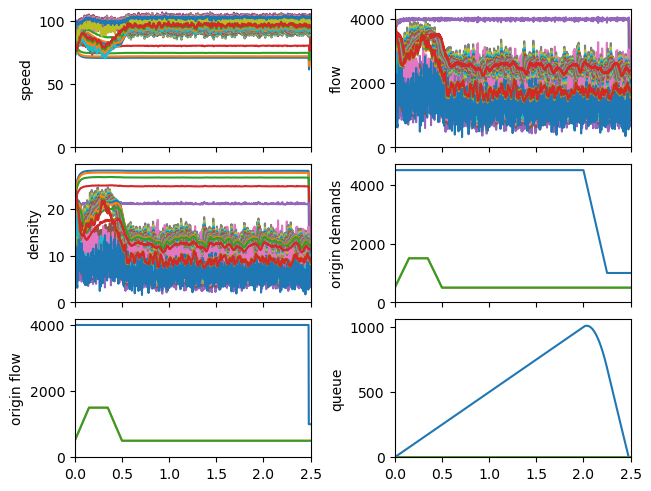

In [2]:
# compute TTS metric (Total-Time-Spent)
links_lengths = [i[-1].L for i in iter(net.links)]
links_numbers = [i[-1].N for i in iter(net.links)]
all_segment_lengths = []
for i in range(len(links_lengths)):
    all_segment_lengths.extend([links_lengths[i]]*links_numbers[i])
tts = T * sum((rho * all_segment_lengths * lanes).sum() + w.sum() for rho, w in zip(RHO, W))
print(f"TTS = {tts:.3f} veh.h")

# plot
_, axs = plt.subplots(3, 2, constrained_layout=True, sharex=True)
axs[0, 0].plot(time, V)
axs[0, 0].set_ylabel("speed")
axs[0, 1].plot(time, Q)
axs[0, 1].set_ylabel("flow")
axs[1, 0].plot(time, RHO)
axs[1, 0].set_ylabel("density")
axs[1, 1].plot(time, demands)
axs[1, 1].set_ylabel("origin demands")
axs[2, 0].plot(time, Q_o)
axs[2, 0].set_ylabel("origin flow")
axs[2, 1].plot(time, W)
axs[2, 1].set_ylabel("queue")
axs[0, 0].set_xlim(0, Tfin)
for ax in axs.flat:
    ax.set_ylim(0, ax.get_ylim()[1])
plt.show()


# 事故测试

### 事故仿真

TTS = 7873.122 veh.h


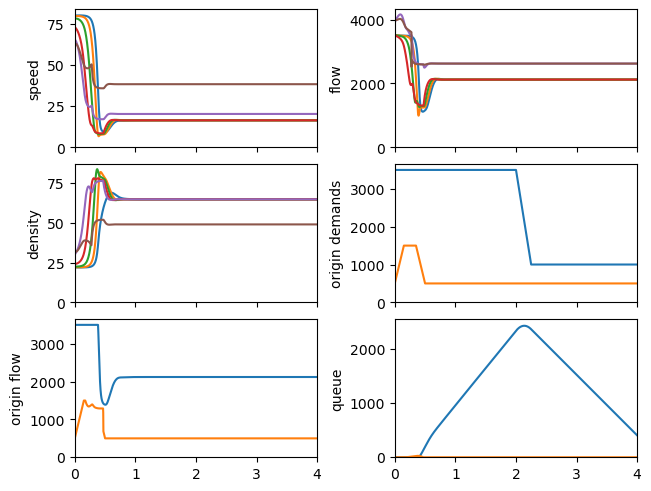

In [88]:
"""
Reproduces the results in Figure 6.5 of [1].

References
----------
[1] Hegyi, A., 2004. Model predictive control for integrating traffic control measures.
    Netherlands TRAIL Research School.
"""


import casadi as cs
import matplotlib.pyplot as plt
import numpy as np

import sym_metanet as metanet
from sym_metanet import (
    Destination,
    Link,
    MainstreamOrigin,
    MeteredOnRamp,
    Network,
    Node,
    engines,
)


def create_demands(time: np.ndarray) -> np.ndarray:
    return np.stack(
        (
            np.interp(time, (2.0, 2.25), (3500, 1000)),
            np.interp(time, (0.0, 0.15, 0.35, 0.5), (500, 1500, 1500, 500)),
        )
    )


# parameters
T = 10 / 3600
Tfin = 4
time = np.arange(0, Tfin, T)
L = 1
lanes = 2
C = (4000, 2000,)
tau = 18 / 3600
kappa = 40
eta = 60
delta = 0.0122
a1 = 1.867
rho_crit1 = 33.5
rho_max1 = 180
v_free1 = 102
a2 = 1.867
rho_crit2 = 30
rho_max2 = 160
v_free2 = 110
# build network
N1 = Node(name="N1")
N2 = Node(name="N2")
N3 = Node(name="N3")
O1 = MainstreamOrigin[cs.SX](name="O1")
O2 = MeteredOnRamp[cs.SX](C[1], name="O2")
D1 = Destination[cs.SX](name="D1")
L1 = Link[cs.SX](4, lanes, L, rho_max1, rho_crit1, v_free1, a1, name="L1")
L2 = Link[cs.SX](2, lanes, L, rho_max2, rho_crit2, v_free2, a2, name="L2")
net = (
    Network(name="A1")
    .add_path(origin=O1, path=(N1, L1, N2, L2, N3), destination=D1)
    .add_origin(O2, N2)
)

# make a casadi function out of the network
engines.use("casadi", sym_type="SX")
# engines.use("numpy")
net.is_valid(raises=True)
net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
F = metanet.engine.to_function(
    net=net,
    more_out=True,
    compact=1,
    T=T,
)
# F: (rho[6], v[6], w[2], v_ctrl, r, d[2]) -> (rho+[6], v+[6], w+[2], q[6], q_o[2])

# create demands
demands = create_demands(time).T

# create initial conditions
rho = cs.DM([22, 22, 22.5, 24, 30, 32])
v = cs.DM([80, 80, 78, 72.5, 66, 62])
w = cs.DM([0, 0])

# simulate
v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
r = cs.DM.ones(1, 1)  # ramp metering rates at O2
RHO, V, W, Q, Q_o = [], [], [], [], []
for d in demands[:100,:]:
    rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, np.array([1,1]), d)
    RHO.append(rho)
    V.append(v)
    W.append(w)
    Q.append(q)
    Q_o.append(q_o)
"""接续
并在原有L2处第二个segment创造事故,使其车道数减少1"""
N1 = Node(name="N1")
N2 = Node(name="N2")
N3 = Node(name="N3")
N4 = Node(name="N4")

O1 = MainstreamOrigin[cs.SX](name="O1")
O2 = MeteredOnRamp[cs.SX](C[1], name="O2")
D1 = Destination[cs.SX](name="D1")
L1 = Link[cs.SX](4, lanes, L, rho_max1, rho_crit1, v_free1, a1, name="L1")
L2 = Link[cs.SX](2-1, lanes, L, rho_max2, rho_crit2, v_free2, a2, name="L2")
L3 = Link[cs.SX](1, lanes-0.6, L, rho_max2, rho_crit2, v_free2, a2, name="L3")
net = (
    Network(name="A1")
    .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4), destination=D1)
    .add_origin(O2, N2)
)

# make a casadi function out of the network
engines.use("casadi", sym_type="SX")
net.is_valid(raises=True)
# 更新模型参数

net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
F = metanet.engine.to_function(net=net, more_out=True, compact=1, T=T)
for d in demands[100:,:]:
    rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r,np.array([1,1,1]), d)
    RHO.append(rho)
    V.append(v)
    W.append(w)
    Q.append(q)
    Q_o.append(q_o)
RHO, V, W, Q, Q_o = (np.squeeze(o) for o in (RHO, V, W, Q, Q_o))  # type: ignore


# compute TTS metric (Total-Time-Spent)
tts = T * sum((rho * L * lanes).sum() + w.sum() for rho, w in zip(RHO, W)) #TTS的计算未考虑车道数变化
print(f"TTS = {tts:.3f} veh.h")

# plot
_, axs = plt.subplots(3, 2, constrained_layout=True, sharex=True)
axs[0, 0].plot(time, V)
axs[0, 0].set_ylabel("speed")
axs[0, 1].plot(time, Q)
axs[0, 1].set_ylabel("flow")
axs[1, 0].plot(time, RHO)
axs[1, 0].set_ylabel("density")
axs[1, 1].plot(time, demands)
axs[1, 1].set_ylabel("origin demands")
axs[2, 0].plot(time, Q_o)
axs[2, 0].set_ylabel("origin flow")
axs[2, 1].plot(time, W)
axs[2, 1].set_ylabel("queue")
axs[0, 0].set_xlim(0, Tfin)
for ax in axs.flat:
    ax.set_ylim(0, ax.get_ylim()[1])
plt.show()

# 测试to_function

In [82]:
from itertools import chain, product
from typing import TYPE_CHECKING, Any, Generic, Literal, Optional, TypeVar, Union

import casadi as cs

from sym_metanet.blocks.base import ElementWithVars
from sym_metanet.engines.core import (
    DestinationsEngineBase,
    EngineBase,
    LinksEngineBase,
    NodesEngineBase,
    OriginsEngineBase,
)

if TYPE_CHECKING:
    from sym_metanet.blocks.links import Link
    from sym_metanet.network import Network


VarType = TypeVar("VarType", cs.SX, cs.MX)
def _filter_vars(
    vars,  independent=True):


    def filter(var):
        if isinstance(var, cs.SX):
            if not independent or all(var[i].n_dep() == 0 for i in range(var.size1())):
                return var
            varlists = cs.symvar(var)
            if len(varlists) == var.size1():
                return cs.vcat(varlists)

        if isinstance(var, cs.MX):
            if not independent or var.n_dep() == 0:
                return var
            varlists = cs.symvar(var)
            if len(varlists) == 1:
                return varlists[0]

        return None

    filtered_vars = {}
    for name, var in vars.items():
        filtered = filter(var)
        if filtered is not None:
            filtered_vars[name] = filtered
    return filtered_vars
def _gather_inputs(
    x: dict[ElementWithVars, dict[str, VarType]],
    u: dict[ElementWithVars, dict[str, VarType]],
    d: dict[ElementWithVars, dict[str, VarType]],
    compact: int,
) -> tuple[list[str], list[VarType]]:
    """Internal utility to gather inputs for `casadi.Function`."""

    if compact <= 0:
        # no aggregation
        names_in, args_in = [], []
        for vars_in in (x, u, d):
            for el, vars in vars_in.items():  # type: ignore[attr-defined]
                for varname, var in vars.items():
                    names_in.append(f"{varname}_{el.name}")
                    args_in.append(var)
        return names_in, args_in

    # group variables as (name, list of vars)
    states: dict[str, list[VarType]] = {}
    actions: dict[str, list[VarType]] = {}
    disturbances: dict[str, list[VarType]] = {}
    for vars_in, group in [(x, states), (u, actions), (d, disturbances)]:
        for el, vars in vars_in.items():  # type: ignore[attr-defined]
            for varname, var in vars.items():
                if varname in group:
                    group[varname].append(var)
                else:
                    group[varname] = [var]

    # group variables as (name, symbol)
    for group in (states, actions, disturbances):
        for varname, list_of_vars in group.items():
            group[varname] = cs.vcat(list_of_vars)

    # add to names and args
    if compact == 1:
        names_in = list(chain(states.keys(), actions.keys(), disturbances.keys()))
        args_in = list(chain(states.values(), actions.values(), disturbances.values()))
    else:
        names_in = ["x", "u", "d"]
        args_in = [
            cs.vcat(states.values()),
            cs.vcat(actions.values()),
            cs.vcat(disturbances.values()),
        ]
    return names_in, args_in
def _gather_outputs(
    x_next: dict[ElementWithVars, dict[str, VarType]],
    compact: int,
) -> tuple[list[str], list[VarType]]:
    """Internal utility to gather outputs for `casadi.Function`."""

    if compact <= 0:
        # no aggregation
        names_out, args_out = [], []
        for el, vars in x_next.items():
            for varname, var in vars.items():
                names_out.append(f"{varname}_{el.name}+")
                args_out.append(var)
        return names_out, args_out

    # group variables as (name, list of vars)
    next_states: dict[str, list[VarType]] = {}
    for vars in x_next.values():
        for varname, var in vars.items():
            varname += "+"
            if varname in next_states:
                next_states[varname].append(var)
            else:
                next_states[varname] = [var]

    # group variables as (name, symbol)
    for varname, list_of_vars in next_states.items():
        next_states[varname] = cs.vcat(list_of_vars)

    # add to names and args
    if compact == 1:
        names_out = list(next_states.keys())
        args_out = list(next_states.values())
    else:
        names_out = ["x+"]
        args_out = [cs.vcat(next_states.values())]
    return names_out, args_out
x = {el: _filter_vars(vars) for el, vars in net.states.items()}
u = {el: _filter_vars(vars) for el, vars in net.actions.items()}
d = {el: _filter_vars(vars) for el, vars in net.disturbances.items()}
names_in, args_in = _gather_inputs(x, u, d, compact=2)

x_next = {
    el: _filter_vars(vars, independent=False)
    for el, vars in net.next_states.items()
}
names_out, args_out = _gather_outputs(x_next, compact=0
                                      )


### 优化

In [ ]:
from scipy.optimize import minimize
rho = cs.DM([22, 22, 22.5, 24, 30, 32])
v = cs.DM([80, 80, 78, 72.5, 66, 62])
w = cs.DM([0, 0])

# simulate
v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
r = cs.DM.ones(1, 1)  # ramp metering rates at O2
def loss_function(Q_sim, V_sim, Q_real, V_real):
    return np.sqrt(np.mean((Q_sim - Q_real) ** 2)) + 0.01*np.sqrt(np.mean((V_sim - V_real) ** 2))
# 假设你有真实的流量和速度数据
Q_real = Q[::30,:]#(Q[::30,:]+np.random.normal(0, 100, Q[::30,:].shape)).clip(0)
V_real = V[::30,:]#(V[::30,:]+np.random.normal(0, 2, V[::30,:].shape)).clip(0)
# 定义一个优化目标函数
def objective(params):
    t_simulation = 10  # 仿真步长（单位：秒）
    t_measure = 300    # 测量时长（单位：秒）
    # 计算采样间隔
    sampling_interval = int(t_measure / t_simulation)  # 采样间隔
    
    
    # tau, kappa, eta, rho_max, delta, a, rho_crit, v_free = params
    tau, kappa, eta, delta, a1, rho_crit1, rho_max1, v_free1, a2, rho_crit2, rho_max2, v_free2, init_lane_drop_acc = params
    global rho
    global v
    global w
    
    N1 = Node(name="N1")
    N2 = Node(name="N2")
    N3 = Node(name="N3")
    O1 = MainstreamOrigin[cs.SX](name="O1")
    O2 = MeteredOnRamp[cs.SX](C[1], name="O2")
    D1 = Destination[cs.SX](name="D1")
    L1 = Link[cs.SX](4, lanes, L, rho_max1, rho_crit1, v_free1, a1, name="L1")
    L2 = Link[cs.SX](2, lanes, L, rho_max2, rho_crit2, v_free2, a2, name="L2")
    net = (
        Network(name="A1")
        .add_path(origin=O1, path=(N1, L1, N2, L2, N3), destination=D1)
        .add_origin(O2, N2)
    )

    # make a casadi function out of the network
    engines.use("casadi", sym_type="SX")
    net.is_valid(raises=True)
    # 更新模型参数
    
    net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
    F = metanet.engine.to_function(net=net, more_out=True, compact=1, T=T)
    
    # 重新仿真
    rho = cs.DM([22, 22, 22.5, 24, 30, 32])
    v = cs.DM([80, 80, 78, 72.5, 66, 62])
    w = cs.DM([0, 0])

    # simulate
    v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
    r = cs.DM.ones(1, 1)  # ramp metering rates at O2
    RHO, V, Q, _, _ = [], [], [], [], []
    for d in demands[:100,:]:
        rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, np.array([1,1]), d)
        RHO.append(rho)
        V.append(v)
        Q.append(q)

    """接续
    并在原有L2处第二个segment创造事故,使其车道数减少1"""
    N1 = Node(name="N1")
    N2 = Node(name="N2")
    N3 = Node(name="N3")
    N4 = Node(name="N4")

    O1 = MainstreamOrigin[cs.SX](name="O1")
    O2 = MeteredOnRamp[cs.SX](C[1], name="O2")
    D1 = Destination[cs.SX](name="D1")
    L1 = Link[cs.SX](4, lanes, L, rho_max1, rho_crit1, v_free1, a1, name="L1")
    L2 = Link[cs.SX](1, lanes, L, rho_max2, rho_crit2, v_free2, a2, name="L2")
    L3 = Link[cs.SX](1, lanes-init_lane_drop_acc, L, rho_max2, rho_crit2, v_free2, a2, name="L3")
    net = (
        Network(name="A1")
        .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4), destination=D1)
        .add_origin(O2, N2)
    )

    # make a casadi function out of the network
    engines.use("casadi", sym_type="SX")
    net.is_valid(raises=True)
    # 更新模型参数
    
    net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
    F = metanet.engine.to_function(net=net, more_out=True, compact=1, T=T)
    
    # 重新仿真
    rho = rho#cs.DM([22, 22, 22.5, 24, 30, 32])
    v = v#cs.DM([80, 80, 78, 72.5, 66, 62])
    w = w#cs.DM([0, 0])

    # simulate
    v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
    r = cs.DM.ones(1, 1)  # ramp metering rates at O2
    
    
    for d in demands[100:,:]:
        rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, np.array([1,1,1]),d)
        RHO.append(rho)
        V.append(v)
        Q.append(q)    
    global Q_sim,V_sim
    
    # 计算损失
    Q_sim = np.squeeze(Q)
    V_sim = np.squeeze(V)
    
    # 检查是否有无效值
    if np.any(np.isnan(Q_sim)) or np.any(np.isnan(V_sim)):
        print("NaN detected in simulation results.")
        return np.inf  # 返回无穷大，表示损失无效
    print(loss_function(Q_sim[::sampling_interval,:], V_sim[::sampling_interval,:], Q_real, V_real))
    return loss_function(Q_sim[::sampling_interval,:], V_sim[::sampling_interval,:], Q_real, V_real)

# 初始参数
init_tau = 5e-3
init_kappa = 40
init_eta = 60
init_delta = 1.0122
init_a1, init_rho_crit1, init_rho_max1, init_v_free1 = [1.867, 33.5, 180, 102]
init_a2, init_rho_crit2, init_rho_max2, init_v_free2 = [1.867, 30, 160, 110]
init_lane_drop_acc = 1
initial_params = [init_tau, init_kappa, init_eta, init_delta, init_a1, init_rho_crit1, init_rho_max1, init_v_free1, init_a2, init_rho_crit2, init_rho_max2, init_v_free2,init_lane_drop_acc]
# 优化参数
result = minimize(objective, initial_params, bounds=[(0, 200)] * len(initial_params),method='Nelder-Mead',options={'xatol': 1e-1, 'fatol': 1e-1, 'maxfev': 1000})
# 输出最优参数
optimal_params = result.x
print("Optimal parameters:", optimal_params)

### 效果展示

In [ ]:
import matplotlib.pyplot as plt
number = 1
rho_real = Q_real/V_real
rho_sim = Q_sim/V_sim
if number ==5:
    rho_real[:4,number] = rho_real[:4,number]/2 
    rho_sim[:100,number] = rho_sim[:100,number]/2 
fig,axs = plt.subplots(3,1,figsize=(13,7))
axs[0].plot(Q_real[:,number],label="real_flow")
axs[0].plot(Q_sim[::30,number],label="sim_flow")
axs[1].plot(V_real[:,number],label="real_speed")
axs[1].plot(V_sim[::30,number],label="sim_speed")
axs[2].plot(rho_real[:,number],label="real_density")
axs[2].plot(rho_sim[::30,number],label="sim_density")
for i in range(3):
    axs[i].set_ylim(bottom=0)
    axs[i].legend(loc='lower right')